# Developing Classifiers for GBs

This notebook demonstrates how GBs can be created specifying lattice type, GB normal and CSL $\Sigma$.  
A. Banadaki's and S. Patala's GBpy and the Atomistic Simulation Environment are used to this end. After the GB is successfully created a fcc single crystal is set up as well. Then both crystals are rattled and a probabilistic classifier developed to differentiate between GB and non-GB atoms.

Note that in the step below where the two crystal halfs are stacked to create the GB crystal care needs to be taken that the axis along which the crystals are stacked is actually correct. The crystals in the $\Sigma$ 5 (001) twist case, for example, were found to have flipped $y$ and $z$ axis.

Literature: A. Banadaki and S. Patala, A simple faceting model for the interfacial and cleavage energies of Σ3 grain boundaries in the complete boundary plane orientation space, Computational Materials Science, 2016.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import atomtoolbox as atb

from ase.visualize import view
from ase import build

from scipy import stats
import copy
from ase.lattice.cubic import FaceCenteredCubic, SimpleCubicFactory
from ase.spacegroup import crystal

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

import os
import pickle
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]

E:\Programs\Anaconda3\envs\py35\lib\site-packages\ase\lattice\spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


## 1. Computing Lattice Directions from GB Normal and CSL $\Sigma$

In [2]:
# inds_po = np.array([2,3,1],dtype=np.int64)
# sigma = '7'
# sigma_number = 0

# inds_po = np.array([7,4,3],dtype=np.int64)
# sigma = '3'
# sigma_number = 0

# inds_po = np.array([1,1,1],dtype=np.int64)
# sigma = '3'
# sigma_number = 0

# inds_po = np.array([2,3,1],dtype=np.int64)
# sigma = '7'
# sigma_number = 0

inds_po = np.array([0,0,1],dtype=np.int64) # Sigma 5 (001) twist
sigma = '5' # the sigma value
sigma_number = 0 # each sigma may have more than one rotation matrix associated with it
bravais_lattice = "fcc" # fcc is the only one currently supported

afcc = 4.05 # lattice constant
# compute lattice directions for both the lower and upper crystal
directions = atb.get_bicrystal_directions(inds_po, bravais_lattice=bravais_lattice,
                                          lattice_constant=afcc, sigma=sigma, 
                                          sigma_number=sigma_number, verbose=True)
print("directions ",directions)

pkl_file  E:/PetProjects/GBpy/GBpy/pkl_files/cF_Id_csl_common_rotations.pkl

GB normal (fcc):
    lower crystal orthogonal indices: [0 0 1]
    lower crystal primitive miller indices: [1 1 0]

Transformation matrix (sigma = 5):
    Sigma = [[ 0.8 -0.4  0.2]
 [ 0.6  1.2  0.4]
 [-0.6 -0.2  0.6]]
    T_p1->p2 = [[  1.00000000e+00   2.68389563e-17   2.51513488e-17]
 [ -1.60708209e-16   8.00000000e-01  -6.00000000e-01]
 [ -4.82981282e-17   6.00000000e-01   8.00000000e-01]]
directions  {'upper': {'y': array([ 1.,  0.,  0.]), 'z': array([ 0, -3,  4], dtype=int64), 'x': array([ 0.,  4.,  3.])}, 'lower': {'y': array([1, 0, 0], dtype=int64), 'z': array([0, 0, 1], dtype=int64), 'x': array([0, 1, 0], dtype=int64)}}


## 2. Merging Upper and Lower Crystal

In [3]:
crystals = atb.get_crystals(directions,symbol="Al", scale_up=True, verbose=True, lattice_constant=afcc)

print("\nNew crytsal cells:")
for label in sorted(crystals):
    print(label,crystals[label].get_cell())

# merging both halfs to a single crystal
# Note: the GB axis may flip around, so please check when merging that you are merging along
# the correct axis, e.g. for Sigma 5 (001) it was observed that the twist axis flipped to [010]
# instead of remaining [001]
size = (5,5,5)
complete_gb_crystal = build.stack(crystals["lower"]*size,crystals["upper"]*size,axis=1)

print("Final crystal cell:",complete_gb_crystal.get_cell())

# show 3D representation
view(complete_gb_crystal)


lower
dealing with it...

upper
dealing with it...
size1 =  (5, 1, 5)
size2 =  (1, 1, 1)

New crytsal cells:
lower [[ 20.25   0.     0.  ]
 [  0.     4.05   0.  ]
 [  0.     0.    20.25]]
upper [[ 20.25   0.     0.  ]
 [  0.     4.05   0.  ]
 [  0.     0.    20.25]]
Final crystal cell: [[ 101.25    0.      0.  ]
 [   0.     40.5     0.  ]
 [   0.      0.    101.25]]


## 3. Generating a Collection of Ideal Crystals

In [4]:
# storing the GB crystal
atoms_dict = {"sig_{}_{}_{}".format(sigma,sigma_number,tuple(inds_po)): complete_gb_crystal}

# storing an fcc Al single crystal
afccAl = 4.05
atoms_fccAl = crystal('Al', [(0,0,0)], spacegroup=225, cellpar=[afccAl, afccAl, afccAl, 90, 90, 90],
                     size=tuple(size), pbc=(1,1,1))
atoms_dict["Al"] = atoms_fccAl

## 4. Rattling Crystals

In [5]:
# number of rattled version of each crystal
Nrattle = 5

# collection of random variables (rvs) to draw displacements for the rattling from
# an increasing in 'scale' parameter is equivalent to more severe rattling
rattle_rvs = [stats.norm(loc=0,scale=.001), stats.norm(loc=0,scale=.005),
              stats.norm(loc=0,scale=.01), stats.norm(loc=0,scale=.02),]
# collection of class instances for the rattling
CRs = [atb.CrystalRattler(rattle_rv=rattle_rv) for rattle_rv in rattle_rvs]

# doing the rattling and storing
rpositions, Natoms, cells, species = None, None, None, None
crystal_names = []
all_rattled_positions = dict()
t_l = []
for sname in sorted(atoms_dict):
    print("rattling ",sname)
    rpositions, Natoms, cells, species = atb.rattle_crystal_multiple_rvs(Nrattle, rattle_rvs,\
                                atoms_dict[sname], rpositions=rpositions, Natoms=Natoms,\
                                species=species, cells=cells)
    t_l.append([sname for v in range(Nrattle*len(rattle_rvs)*atoms_dict[sname].positions.shape[0])])
    crystal_names.extend([sname for v in range(Nrattle*len(rattle_rvs))])
    
rpositions_flat, Natoms_flat, cells_flat, species_flat = atb.flattening_rattled_crystal_data(rpositions,\
                                                    Natoms, cells, species)
crystal_names = np.array(crystal_names, dtype=str)
t_l_flat = np.hstack(t_l)
print("t_l_flat {}".format(len(t_l_flat)))
print("rpositions_flat {}, Natoms_flat {} atoms total {}, cells_flat {}, species_flat {}".format(len(rpositions_flat), len(Natoms_flat), sum(Natoms_flat), len(cells_flat), len(species_flat)))

rattling  Al
rattling  sig_5_0_(0, 0, 1)
t_l_flat 510000
rpositions_flat 40, Natoms_flat 40 atoms total 510000, cells_flat 40, species_flat 40


## 5. Setting up Design Matrices

In [6]:
# defining the filter for atom elements in the local neighborhood
all_filter = lambda s,s_ref: np.array([True for v in range(s.shape[0])])

## Neighbourhood search conditions 
# Note that r_cut is currently required for the ultracell generation as well as neighbourhood search.
# If num_neigh is not equal to None then num_neigh takes precedence in the neighbourhood search
# over r_cut. r_cut then needs to be sufficiently large to provide the adequate amount of neighbours.
r_cut = 6. 
num_neigh = 18

## feature parameters - only Bond Order Parameters (BOP) here
bopf_params = {"k":[4,6],"element_filter":all_filter,"kind":"3"}

featurers = [atb.BondOrderParameterFeatures]
featurer_params = [bopf_params]

all_Phis = []
Phis_dict = {}
for i in range(len(rpositions_flat)): # looping rattle rv & crystal type
    #if i%10==0:
    print("\n{}/{}".format(i+1,len(rpositions_flat)))
    print("    crystal ",crystal_names[i])
    _pos = rpositions_flat[i]
    _cell = cells_flat[i]
    _spec = species_flat[i]

    _Phi, mapper = atb.get_crystal_design_matrix(positions=_pos, species=_spec, cell=_cell, r_cut=r_cut, 
                                    num_neigh=num_neigh,
                                    features_class=featurers, params_features=featurer_params, 
                                    return_force=False, return_mapper=True)
    
    # storing Phis
    assert np.isfinite(_Phi).all(), "_Phi contains non-finite values."
    if i == 0:
        Phi = np.copy(_Phi)
    else:
        Phi = np.vstack((Phi,_Phi))
    print("    size of Phi =",Phi.shape)
    all_Phis.append(_Phi)
    
    _name = crystal_names[i]
    if not _name in Phis_dict:
        Phis_dict[_name] = _Phi
    else:
        Phis_dict[_name] = np.vstack((Phis_dict[_name],_Phi))


1/40
    crystal  Al
    size of Phi = (500, 2)

2/40
    crystal  Al
    size of Phi = (1000, 2)

3/40
    crystal  Al
    size of Phi = (1500, 2)

4/40
    crystal  Al
    size of Phi = (2000, 2)

5/40
    crystal  Al
    size of Phi = (2500, 2)

6/40
    crystal  Al
    size of Phi = (3000, 2)

7/40
    crystal  Al
    size of Phi = (3500, 2)

8/40
    crystal  Al
    size of Phi = (4000, 2)

9/40
    crystal  Al
    size of Phi = (4500, 2)

10/40
    crystal  Al
    size of Phi = (5000, 2)

11/40
    crystal  Al
    size of Phi = (5500, 2)

12/40
    crystal  Al
    size of Phi = (6000, 2)

13/40
    crystal  Al
    size of Phi = (6500, 2)

14/40
    crystal  Al
    size of Phi = (7000, 2)

15/40
    crystal  Al
    size of Phi = (7500, 2)

16/40
    crystal  Al
    size of Phi = (8000, 2)

17/40
    crystal  Al
    size of Phi = (8500, 2)

18/40
    crystal  Al
    size of Phi = (9000, 2)

19/40
    crystal  Al
    size of Phi = (9500, 2)

20/40
    crystal  Al
    size of Phi = 

## 6. Plotting distributions in Feature Space

<IPython.core.display.Javascript object>


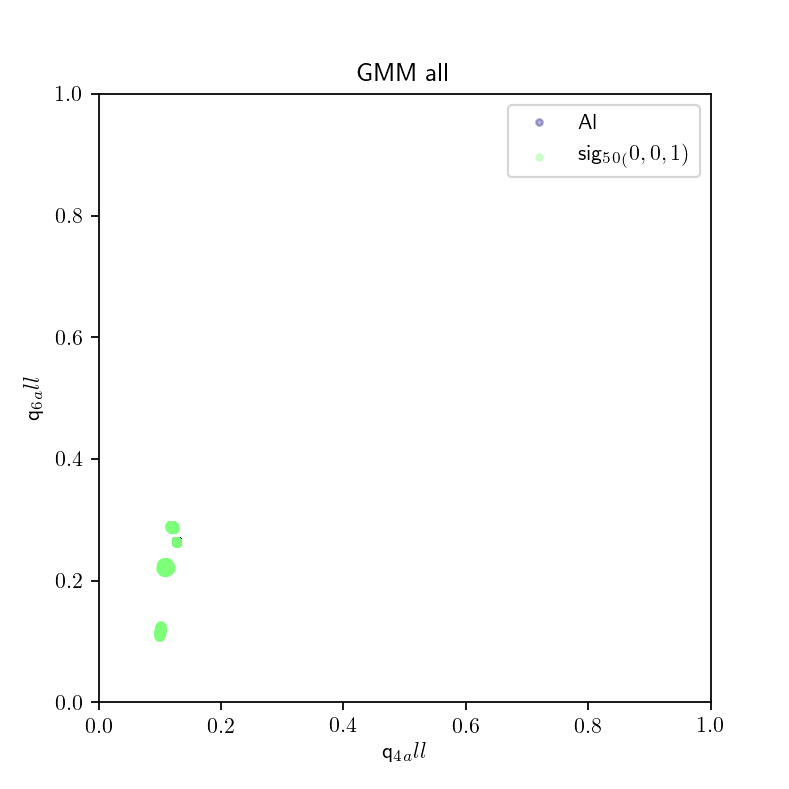

In [7]:
xlim, ylim = (0,1), (0,1)
_labels = np.sort(np.unique(t_l_flat))
color_map = {k:i/float(_labels.shape[0]) for i,k in enumerate(_labels)}

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for _name in sorted(Phis_dict):
    X = Phis_dict[_name]
    ax.plot(X[:,0], X[:,1],'.',label=_name,alpha=.3, color=plt.cm.jet(color_map[_name]))
    #_n += X.shape[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("q_4_all")
ax.set_ylabel("q_6_all")
ax.set_title("GMM all")
plt.legend(loc=0)
plt.show()

## 7. Training a Classifier

In the present example we see that two models are found, with one model being tightly focussed around (~0.128,~0.264) and the other occupying larger areas. The focussed model represents atoms in near ideal fcc configurations. The other model therefore contains all configurations which deviate from fcc. In the present case these deviations only occurr due to the GB, and thus the model relates to the GB atoms.

In [8]:
# choose mixture class
vgmm = BayesianGaussianMixture(n_components=10, weight_concentration_prior=1., 
                               covariance_type="full")
# initialize the classifier class with the chosen mixture class
gmc = atb.GaussianMixtureClassifier(gmm=vgmm, cluster={"method":"average","metric":"euclidean",
                       "threshold":1e-4,"criterion":"distance","cluster_parameters":"mu","combine":"mean"},
                 weights_fit_method="Nelder-Mead", verbose=True)

# fitting the mixtures for all observations
gmc.fit([Phis_dict[k] for k in sorted(Phis_dict)], None, label_map=None)

E:\Programs\Anaconda3\envs\py35\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


number of resulting models:  2
number of components in total:  6


## 8. Visualizing Classifications

<IPython.core.display.Javascript object>


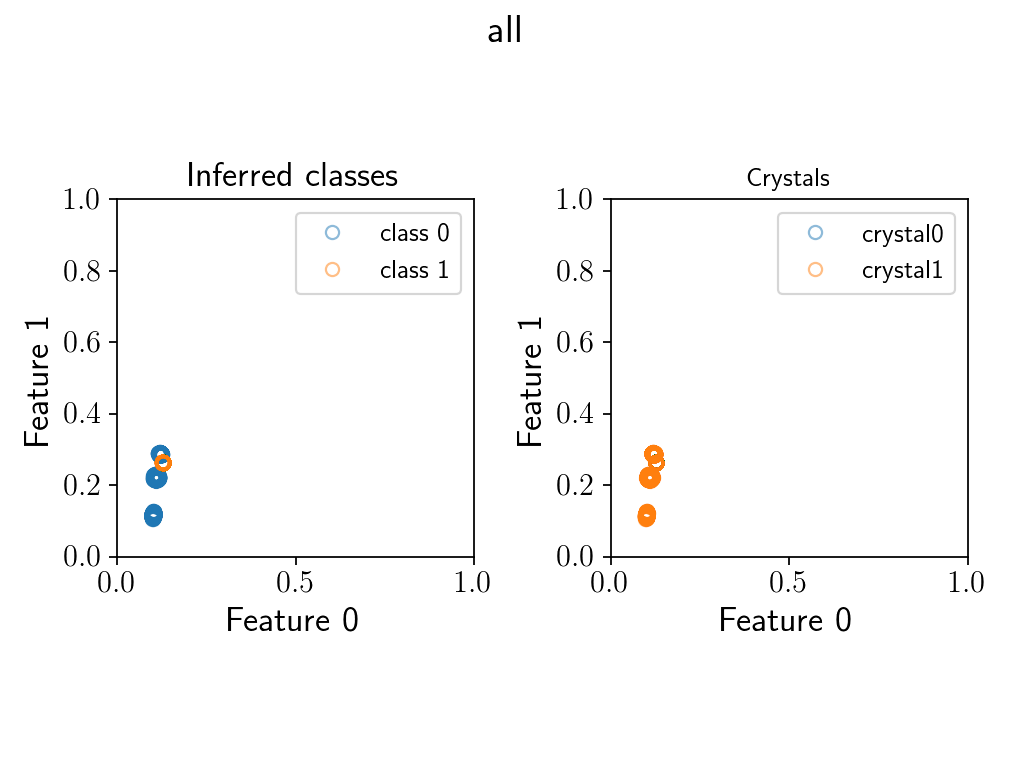

[array([1, 1, 1, ..., 1, 1, 1], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]

In [11]:
# predicting to which model / mixture of Gaussians each atom belongs
gmc.predict([Phis_dict[k] for k in sorted(Phis_dict)], show=True, 
            show_kwargs=dict(axes=[0,1], title="all"))

## 9. Store Classifier

In [12]:
# storing classifier on disk
save_path = "BayesianGaussianMixtureClassifier_sigma5_0_001.pckl"
gmc.save(save_path)

## 10. Plot Things

<IPython.core.display.Javascript object>


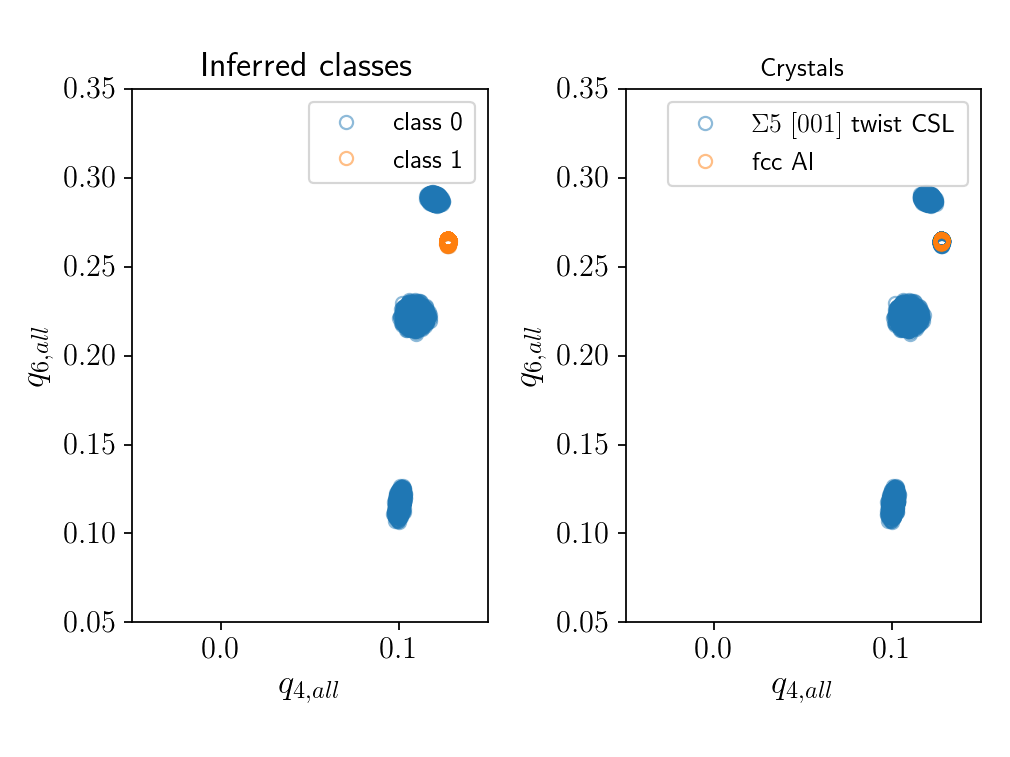

In [13]:
load_path = "BayesianGaussianMixtureClassifier_sigma5_0_001.pckl"
gmc = atb.GaussianMixtureClassifier(load_path=load_path, check_labels=False)

data_labels = ["$\Sigma 5$ $[001]$ twist CSL", "fcc Al"]
keys = sorted(Phis_dict, reverse=True)
classes = gmc.predict([Phis_dict[k] for k in keys])
gmc.show([Phis_dict[k] for k in keys], classes, axes=[0,1], title="",
         xlim=(-.05,.15), ylim=(.05,.35), xlabel=r"$q_{4,all}$",ylabel=r"$q_{6,all}$",
         data_labels=data_labels)